In [7]:
using Turing, Zygote, Distributions, ReverseDiff
using FillArrays
using StatsPlots
using Random
using LinearAlgebra
include("src/EvolutionSimulator.jl")

Turing.setadbackend(:reversediff);
Turing.setrdcache(true)
Random.seed!(3);
Threads.nthreads()

6

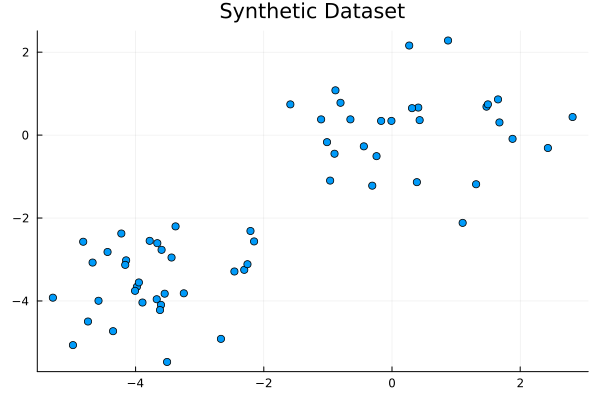

In [3]:
# Define Gaussian mixture model.
w = [0.5, 0.5]
μ = [-3.5, 0.5]
mixturemodel = MixtureModel([MvNormal(Fill(μₖ, 2), I) for μₖ in μ], w)

# We draw the data points.
N = 60
x = rand(mixturemodel, N);
scatter(x[1, :], x[2, :]; legend=false, title="Synthetic Dataset")

In [4]:
@model function gaussian_mixture_model(x)
    # Draw the parameters for each of the K=2 clusters from a standard normal distribution.
    K = 2
    μ ~ MvNormal(Zeros(K), I)

    # Draw the weights for the K clusters from a Dirichlet distribution with parameters αₖ = 1.
    w ~ Dirichlet(K, 1.0)
    # Alternatively, one could use a fixed set of weights.
    # w = fill(1/K, K)

    # Construct categorical distribution of assignments.
    distribution_assignments = Categorical(w)

    # Construct multivariate normal distributions of each cluster.
    D, N = size(x)
    distribution_clusters = [MvNormal(Fill(μₖ, D), I) for μₖ in μ]

    # Draw assignments for each datum and generate it from the multivariate normal distribution.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ distribution_assignments
        x[:, i] ~ distribution_clusters[k[i]]
    end

    return k
end

model = gaussian_mixture_model(x);

In [7]:
sampler = Gibbs(PG(50, :k), HMC(0.05, 10, :μ, :w))
nsamples = 60
nchains = 3
chains = sample(model, sampler, MCMCThreads(), nsamples, nchains);

Sampling (3 threads)   0%|█                             |  ETA: N/A


Sampling (3 threads)  33%|██████████                    |  ETA: 0:02:55


Sampling (3 threads)  67%|████████████████████          |  ETA: 0:00:48


Sampling (3 threads) 100%|██████████████████████████████| Time: 0:01:38
Sampling (3 threads) 100%|██████████████████████████████| Time: 0:01:38


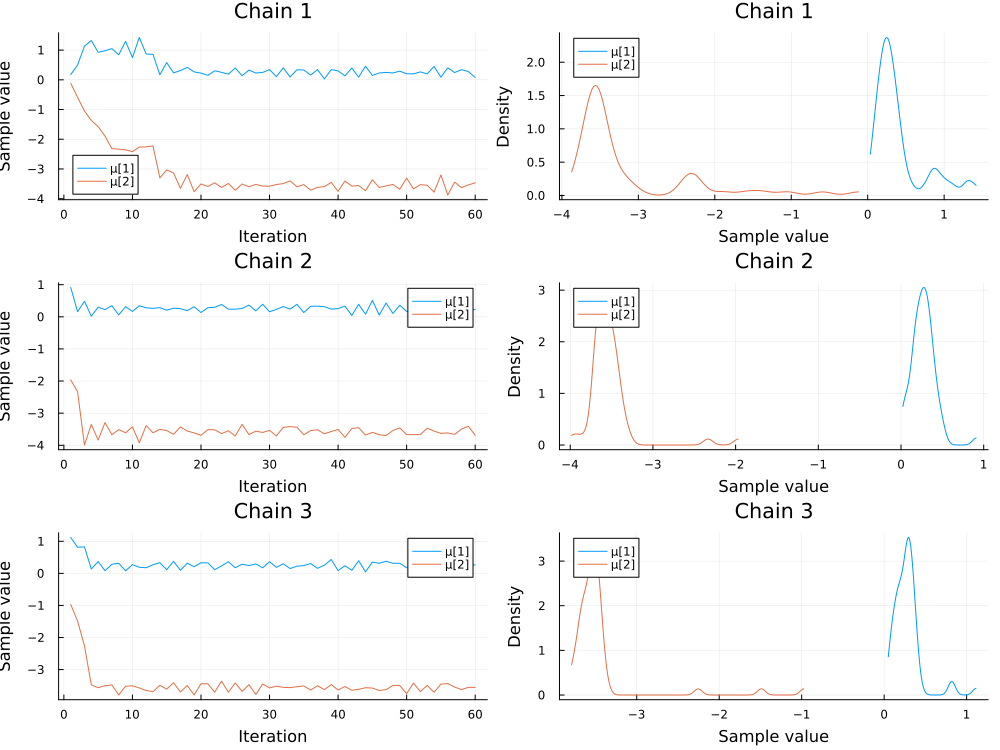

In [9]:
plot(chains[["μ[1]", "μ[2]"]]; colordim=:parameter, legend=true)

In [4]:
# prepare data
human = retrievepdb("1A3N", dir="data/pdb")
chainX, chainY = human["A"], human["B"]
X = vcat(reshape(sequence(chainX), 1, :), angles(chainX))
X[isnan.(X)] .= 0.0
Y = vcat(reshape(sequence(chainY), 1, :), angles(chainY))
Y[isnan.(Y)] .= 0.0

l = 10

X = X[:, 1:l]
Y = Y[:, 1:l]
n = size(X, 2)
m = size(Y, 2)
data = Array{Float64}(undef, 6, max(n, m))
data[1:3, 1:n] .= X
data[4:6, 1:m] .= Y


┌ Info: File exists: 1A3N
└ @ BioStructures D:\Programs\julia_depot\packages\BioStructures\1QcQI\src\pdb.jl:236


3×10 view(::Matrix{Float64}, 4:6, 1:10) with eltype Float64:
 9.0      11.0      17.0      15.0       …  16.0        1.0       20.0
 0.0      -1.24806  -1.47966  -1.29803      -1.12236   -1.0928    -1.14889
 1.93653   2.47863   3.11704  -0.591874     -0.691562  -0.707081  -0.8592

In [2]:
include("src/PairEvol.jl")
using StatsPlots

In [84]:
pair_align(chainX, chainY; t=0.1)


Alignment generated by affine gap combinatorial model
VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHF-DLSH-----GSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
HLTPEEKSAVTALWGKV--NVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH



Sampling (3 threads)   0%|█                             |  ETA: N/A


Sampling (3 threads)  33%|██████████                    |  ETA: 0:03:51
Sampling (3 threads)  67%|████████████████████          |  ETA: 0:00:58


Sampling (3 threads) 100%|██████████████████████████████| Time: 0:01:58


Sampling (3 threads) 100%|██████████████████████████████| Time: 0:01:58

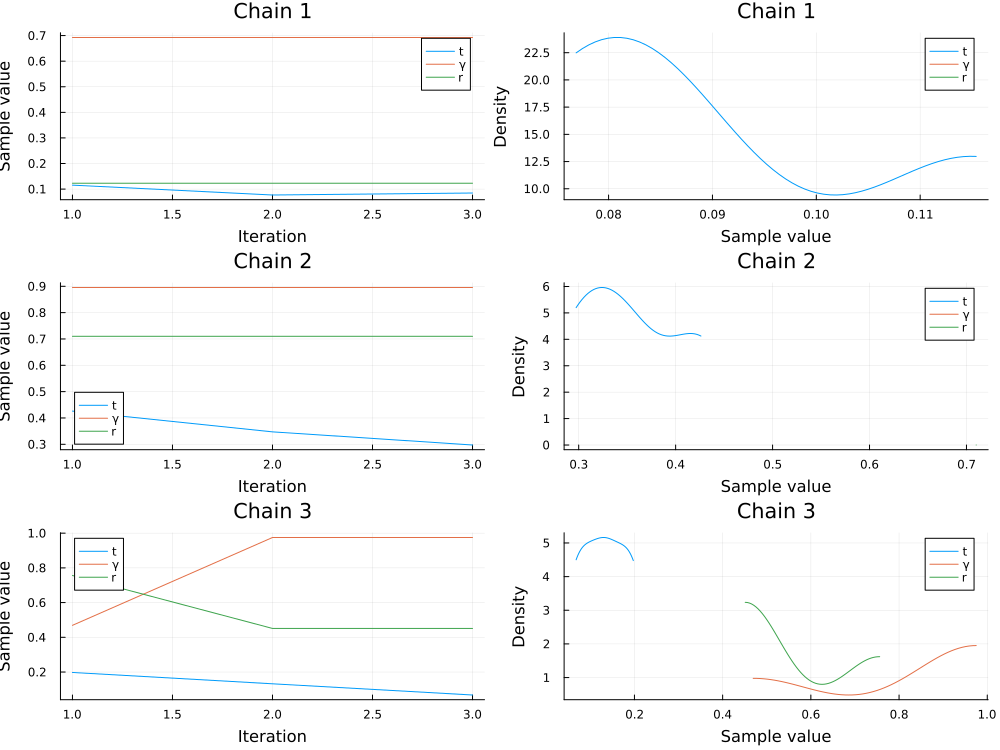

In [7]:
model = PairEvol(data, n, m)
#alg = HMC(0.05, 10, :t, :mean, :var, :γ, :r, :λ, :seq_length)
alg = Gibbs(HMC(0.05, 10, :t), MH(:mean, :var, :γ, :r, :λ, :seq_length))
nchains = 3
nsamples = 5
@time chains = sample(model, alg, MCMCThreads(), nsamples, nchains);

# Index the chain with the persistence probabilities.
plot(chains[["t", "r", "γ"]]; colordim=:parameter, legend=true)